# Digital Pathology - Color transformation and normalization

## Introduction
Digital pathology images can be generated by a range of workflows, producing data of varying quality  
ideally, a whole slide image is generated by using a high dpi scanner to digitize a quality slide  
Photography can also be used to generate images from glass slides  

The actual appearance of the slide can be highly dependent on the technical details of the slide preparation process    
color intensity and separation depend on tissue thickness, fixation parameters, staining time, temp, and quality    
variation in the tissue compartment composition can also alter staining intensity   regionally throughout the slide, complicating edge detection and object discrimination  

Methods to extract the maximum in useful information from digital pathology images is an area of active research  
Here we'll review some of the current literature and try out some of these methods to see how they fit into an evolving pipeline  



## Index
* [Introduction] (#Introduction)
* [Lit and linnks] (#lit-and-links)
* [Project Setup] (#project-setup)
* [Image Summarization with Histograms] (#image-summarization-with-histograms)
* [Thresholding] (#thresholding)
* [Masking] (#masking)
* [Opening and Closing] (#opening-and-closing)
* [De-noising] (#de-noising)
* [Edge Detection] (#edge-detection)
* [Image Normalization] (#image-normalization)
* [Color Normalization] (#color-normalizaiton)
* [object detection] (#object-detection)
* [object characterization) (#object characterization)



### Lit and links
Below are some of the results of quick pubmed and googling "histopathology color normalization"]

https://www-sciencedirect-com.pitt.idm.oclc.org/science/article/pii/S0968432818300982#sec0010

https://pubmed.ncbi.nlm.nih.gov/30420242/

https://ieeexplore.ieee.org/document/7337367

https://pubmed.ncbi.nlm.nih.gov/31279982/

https://openreview.net/forum?id=SkjdxkhoG

https://www.jpathinformatics.org/article.asp?issn=2153-3539;year=2016;volume=7;issue=1;spage=17;epage=17;aulast=Sethi

https://ieeexplore.ieee.org/abstract/document/5299287?casa_token=xqF8uqvs49YAAAAA:poC97aHz6IuNZjoSVzbgG9Fj_WWV9evIOx7tdgoqMYP7PaNbRGpwx4hU1MA0i10TqL6JLXK_cQ

https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

https://cs231n.github.io/neural-networks-2/

https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

## Project Setup
To test these color transformation and normalization tools out, i'll be installing and loading several additional packages

htk: 
    

In [1]:
#import histomicstk as htk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
import os
import glob

import skimage as sk
from skimage import exposure


In [2]:
## Load convenience functions for analysis/viz

def plotHist(histTuple, color = 0): 
    vals_hist = histTuple[0]
    vals_bins = histTuple[1]
    
    plt.xlim([0, 255])
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale intensity")
    plt.ylabel("pixels")
    thePlot=plt.plot(a1[0:-1], a0)
    return thePlot

def getHist_color(imfile):
    colorList = ["r", "g", "b"]
    hists_color = [np.histogram(imfile[:,:,ind], bins = 255, range=(0,255)) for ind, color in  enumerate(colorList)]
    return hists_color

def plotHist_color(histTuple, colorVal): 
    vals_hist = histTuple[0]
    vals_bins = histTuple[1]
    
    plt.xlim([0, 255])
    thePlot=plt.plot(vals_bins[0:-1], vals_hist, color=colorVal)
    return thePlot

def viewHist_color(imfile): 
    # tuple to select colors of each channel line
    colors = ("r", "g", "b")
    channel_ids = (0, 1, 2)

    # create the histogram plot, with three lines, one for
    # each color
    plt.xlim([0, 255])
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            imfile[:, :, channel_id], bins=255, range=(0, 255)
        )
        plt.plot(bin_edges[0:-1], histogram, color=c)

    plt.xlabel("Color value")
    plt.ylabel("Pixels")
    plt.title("3 Color Histogram")
    plt.show()

def viewHists_color(imfiles): 
    # Subplots are organized in a Rows x Cols Grid
    # Tot and Cols are known

    Tot = len(imfiles)
    Cols = 2 # generate three column plots for readability

    # Compute Rows required

    Rows = Tot // Cols 
    Rows += Tot % Cols

    # Create a Position index

    Position = range(1,Tot + 1)
    
    # tuple to select colors of each channel line
    colors = ("r", "g", "b")
    channel_ids = (0, 1, 2)
    
    #plt.xlim([0, 255])
    
    fig = plt.figure(1, frameon=False, constrained_layout=False)
    
    # Create a subplot for each image in the image list, adding a set of axes and the plot to the image at the specified position
    
    for index,imfile in enumerate(imfiles):
        ax=fig.add_subplot(Cols,Rows,Position[index], axisbelow=False, frameon=False)
        ax.set_title("Image #"+str(index))
         # create the histogram plot, with three lines, one for
         # each color
        for channel_id, c in zip(channel_ids, colors):
            histogram, bin_edges = np.histogram(
                imfile[:, :, channel_id], bins=255, range=(0, 255)
            )
            plt.plot(bin_edges[0:-1], histogram, color=c)

        #ax.set_xlabel("Color value")
        #ax.set_ylabel("Pixels")
        #ax.title("3 Color Histogram")
    
        #for a in ax: 
        #    a.axis("off")
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=.1)


    plt.show()
    
    #plt.xlabel("Pixel intensity value")
    #plt.ylabel("Count")
    
def viewHists_color_hsv(imfiles): 
    # Subplots are organized in a Rows x Cols Grid
    # Tot and Cols are known

    Tot = len(imfiles)
    Cols = 2 # generate three column plots for readability

    # Compute Rows required

    Rows = Tot // Cols 
    Rows += Tot % Cols

    # Create a Position index

    Position = range(1,Tot + 1)
    
    # tuple to select colors of each channel line
    colors = ("r", "g", "b")
    channel_ids = (0, 1, 2)
    
    #plt.xlim([0, 255])
    
    fig = plt.figure(1, frameon=False, constrained_layout=False)

    # Create a subplot for each image in the image list, adding a set of axes and the plot to the image at the specified position
    
    for index,imfile in enumerate(imfiles):
        ax=fig.add_subplot(Cols,Rows,Position[index], axisbelow=False, frameon=False)
        ax.set_title("Image #"+str(index))
         # create the histogram plot, with three lines, one for
         # each color
        for channel_id, c in zip(channel_ids, colors):
            histogram, bin_edges = np.histogram(
                imfile[:, :, channel_id], bins=255, range=(0, 1)
            )
            plt.plot(bin_edges[0:-1], histogram, color=c)

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=.1)


    plt.show()
    
    #plt.xlabel("Pixel intensity value")
    #plt.ylabel("Count")
    
    
    
    
def viewHists_grey(imfiles): 
    # Subplots are organized in a Rows x Cols Grid
    # Tot and Cols are known

    Tot = len(imfiles)
    Cols = 2 # generate three column plots for readability

    # Compute Rows required

    Rows = Tot // Cols 
    Rows += Tot % Cols

    # Create a Position index

    Position = range(1,Tot + 1)
    
    fig = plt.figure(1, frameon=False, constrained_layout=False)
    plt.xlim([0, 255])

    # Create a subplot for each image in the image list, adding a set of axes and the plot to the image at the specified position
    
    for index,imfile in enumerate(imfiles):
        
        ax=fig.add_subplot(Cols,Rows,Position[index], axisbelow=False, frameon=False)    
        # create the histogram for the single channel of data        
        histogram, bin_edges = np.histogram(imfile, bins=255, range=(0,1))
        
        plt.plot(bin_edges[0:-1], histogram)


    plt.show()




from skimage import img_as_float, img_as_ubyte
def applyThresholdMask(imageFile, threshold): 
    workingIm = img_as_ubyte(imageFile)
    mask = workingIm < threshold
    workingIm[mask] = 0
    return workingIm


def showMultiplot(imfiles, title = "Multiplot"): 
    # Subplots are organized in a Rows x Cols Grid
    # Tot and Cols are known

    Tot = len(imfiles)
    Cols = 2 # generate three column plots for readability

    # Compute Rows required

    Rows = Tot // Cols 
    Rows += Tot % Cols

    # Create a Position index

    Position = range(1,Tot + 1)

    fig = plt.figure(1, frameon=False, constrained_layout=True)
    fig.suptitle(title, ha="left", va="bottom")
    
    # Create a subplot for each image in the image list, adding a set of axes and the plot to the image at the specified position
    for index,imfile in enumerate(imfiles):
        ax=fig.add_subplot(Cols,Rows,Position[index], axisbelow=False, frameon=False)
        ax.imshow(imfile)
        ax.axis("off")
    
    
    plt.show()

def showMultiplot_hsv(imfiles, title = "Multiplot"): 
    # Subplots are organized in a Rows x Cols Grid
    # Tot and Cols are known

    Tot = len(imfiles)
    Cols = 2 # generate three column plots for readability

    # Compute Rows required

    Rows = Tot // Cols 
    Rows += Tot % Cols

    # Create a Position index

    Position = range(1,Tot + 1)

    fig = plt.figure(1, frameon=False, constrained_layout=True)
    fig.suptitle(title, ha="left", va="bottom")
    
    # Create a subplot for each image in the image list, adding a set of axes and the plot to the image at the specified position
    for index,imfile in enumerate(imfiles):
        ax=fig.add_subplot(Cols,Rows,Position[index], axisbelow=False, frameon=False)
        ax.imshow(imfile)
        ax.axis("off")
    
    plt.hsv()
    plt.show()


def showMultiplot_gray(imfiles, title = "Multiplot"): 
    # Subplots are organized in a Rows x Cols Grid
    # Tot and Cols are known

    Tot = len(imfiles)
    Cols = 2 # generate three column plots for readability

    # Compute Rows required

    Rows = Tot // Cols 
    Rows += Tot % Cols

    # Create a Position index

    Position = range(1,Tot + 1)

    fig = plt.figure(1, frameon=False, constrained_layout=True)
    fig.suptitle(title, ha="left", va="bottom")
    
    # Create a subplot for each image in the image list, adding a set of axes and the plot to the image at the specified position
    for index,imfile in enumerate(imfiles):
        ax=fig.add_subplot(Cols,Rows,Position[index], axisbelow=False, frameon=False)
        ax.imshow(imfile, cmap=plt.cm.gray)
        ax.axis("off")
    
    plt.hsv()
    plt.show()


    

## Load the working data

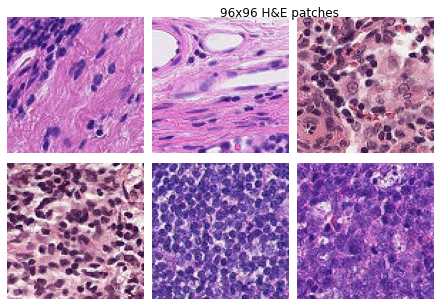

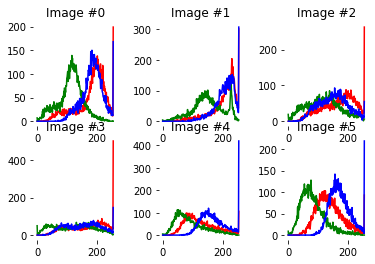

In [3]:
testFilesLoc="/Users/johnalanwillis/Documents/ilc-nodalMet-ML/ilc-nodalMet-ML/datasets/test"

imlocs=[]

imlocs = [f for f in glob.glob(testFilesLoc+"/*.tif")]
imlocs_small=imlocs[0:6]
imlocs_small

imfiles_small=[]

for imloc in imlocs_small: 
    imfiles_small.append(io.imread(imloc))
    
showMultiplot(imfiles_small, "96x96 H&E patches")
viewHists_color(imfiles_small)



## Image data types and transformations
When transforming image data, it is essential to consider how the data is encoded  
working with scikit-image: https://scikit-image.org/docs/stable/user_guide/data_types.html#note-about-negative-values  
> color images read with `skimage.io.imread` will by default be read as 3-channel 64 bit numpy arrays
> single channel images read with `skimage.io.imread` with be read as 1-channel 64 bit numpy arrays  

If necessary, these arrays can be converted to floating point data arrays with the `img_as_float` function

## Global Transformations

## Image Transformation - RGB to Grey
One simple transformation we can attempt to clean up the data is reducing three channel RGB data to single channel greyscale
this was demonstrated in the Image Segmentation notebook using `rgb2grey` from scikit-image

lets quickly review the effect of this operation below

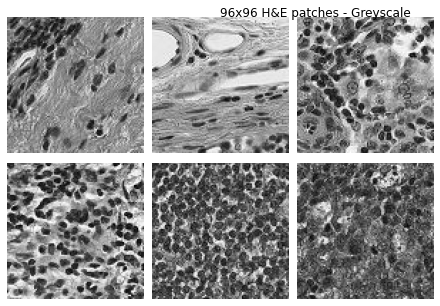

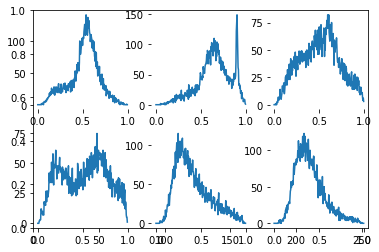

In [4]:
from skimage.color import rgb2gray


imfiles_small_gray=[rgb2gray(imfile) for imfile in imfiles_small]
showMultiplot_gray(imfiles_small_gray, "96x96 H&E patches - Greyscale")
viewHists_grey(imfiles_small_gray)



we see that transforming the three-channel image data into single-channel greyscale didn't add much to the discriminatory power of the histogram. 

Notice that this transformation also scales the data, from 0-255 to 0-1.  
We have to adjust some of our plotting functions to account for this 

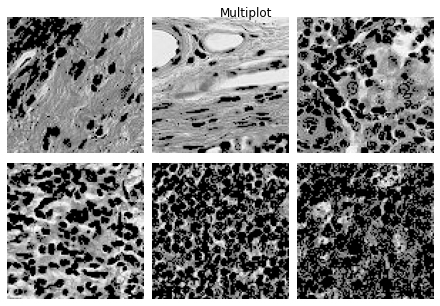

In [5]:
showMultiplot_gray([applyThresholdMask(imfile, 100) for imfile in imfiles_small_gray])

## Image transformation - Change the basis - HSV
Sometimes changing the coordinate axis to one that highlights the difference between objects can be revealing
changing RGB data to the Hue-Saturation-Value color model may emphasize differences more clearly 

Notice that this transformation also scales the data, from 0-255 to 0-1.  
We have to adjust some of our plotting functions to account for this 

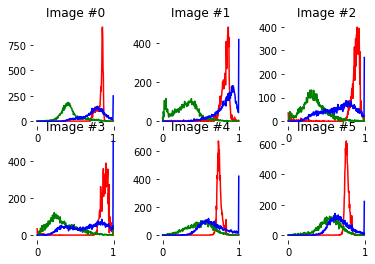

In [6]:
from skimage.color import rgb2hsv

imfiles_small_hsv = [rgb2hsv(imfile) for imfile in imfiles_small]

viewHists_color_hsv(imfiles_small_hsv)


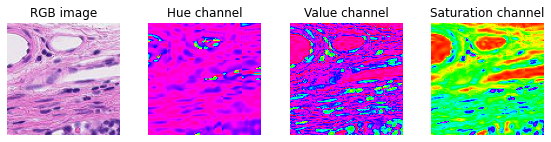

In [7]:
rgb_img = imfiles_small[1]
hsv_img = rgb2hsv(rgb_img)
hue_img = hsv_img[:, :, 0]
sat_img = hsv_img[:, :, 1]
value_img = hsv_img[:, :, 2]

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(8, 2))

plt.hsv()

ax0.imshow(rgb_img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax3.imshow(sat_img, cmap='hsv')
ax3.set_title("Saturation channel")
ax3.axis('off')
ax2.imshow(value_img, cmap='hsv')
ax2.set_title("Value channel")
ax2.axis('off')

fig.tight_layout()


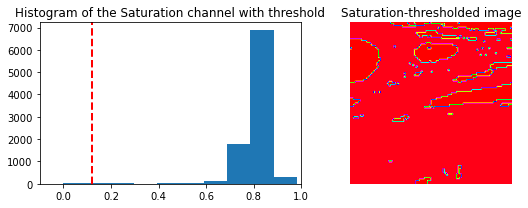

In [8]:
hue_threshold = .12

binary_img = sat_img > hue_threshold

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))

ax0.hist(hue_img.ravel())
ax0.set_title("Histogram of the Saturation channel with threshold")
ax0.axvline(x=hue_threshold, color='r', linestyle='dashed', linewidth=2)
ax0.set_xbound(-0.1,1)
ax1.imshow(binary_img)
ax1.set_title("Saturation-thresholded image")
ax1.axis('off')

fig.tight_layout()

Transforming the data to the hsv basis actually does seem to highlight some differences more clearly than RGB, particularly note the additional s and v peaks highlighted on image 1


## Image transformation - inversion
inversion of an image generates the complement of an image
for binary masks, truth values would swap
for grayscale data, the intensity value is replaced by the difference of the maximum value of the data type and the actual value

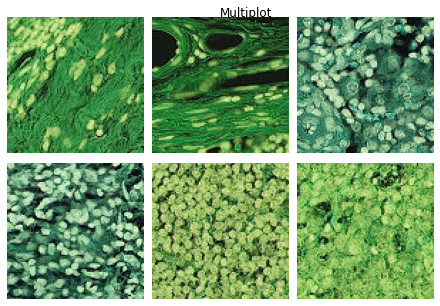

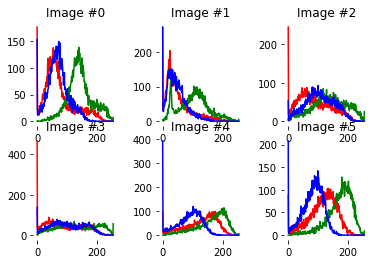

In [9]:
from skimage import util

imfiles_small_inv = [util.invert(imfile) for imfile in imfiles_small]

showMultiplot(imfiles_small_inv)

viewHists_color(imfiles_small_inv)

The inversion  does seem to highlight the nuclei in these H&E images well  
The inversion only flips the histograms however



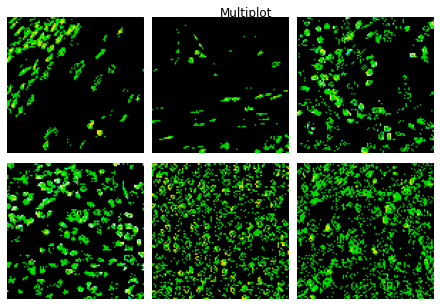

In [10]:
showMultiplot([applyThresholdMask(imfile, 200) for imfile in imfiles_small_inv])

## Image transformation - Exposure and Contrast
Poorly captured data may contain data concentrated only within a portion of its discriminatory range  
while ideally, the data capture would be re-engineered to more appropriately dial in the range of teh measurements to maximize discriminatory power    
some transformations can extract additional information from an image by spreading the useful data across the range

### Gamma Correction
Gamma correction performs a power law transform Output = Input ** gamma on a scaled input matrix

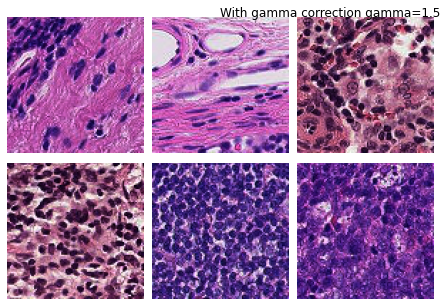

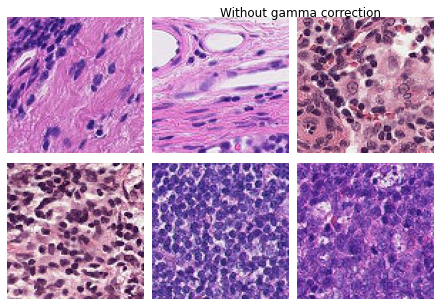

In [11]:
from skimage import exposure

imfiles_small_gamma = [exposure.adjust_gamma(imfile,1.5, gain = 1) for imfile in imfiles_small]

showMultiplot(imfiles_small_gamma, "With gamma correction gamma=1.5")
showMultiplot(imfiles_small, "Without gamma correction")


we see gamma-correcting the images both darkens them and highlights the nuclei

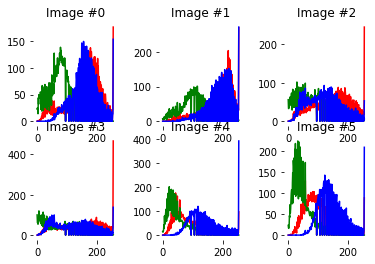

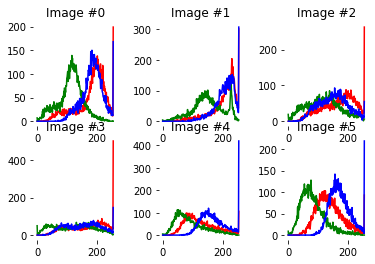

In [12]:
viewHists_color(imfiles_small_gamma)
viewHists_color(imfiles_small)

the histograms from the gamma corrected images have been spread out over the full range of possible intensities

### Image intensity rescaling
the function `rescale_intensity` transforms an ndarray to broaden the distribution of intensity values across the available range


/Users/johnalanwillis/anaconda3/envs/ilcproj/lib/python3.7/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


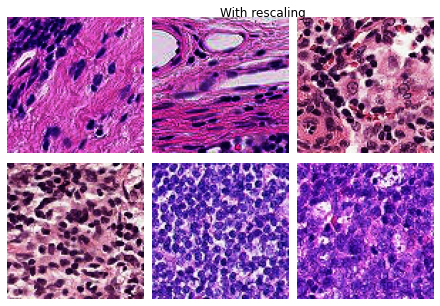

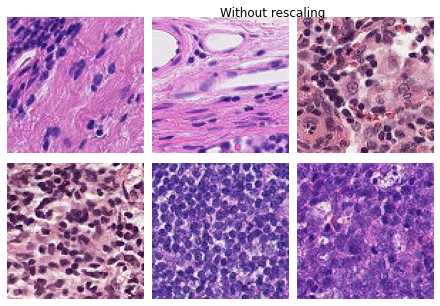

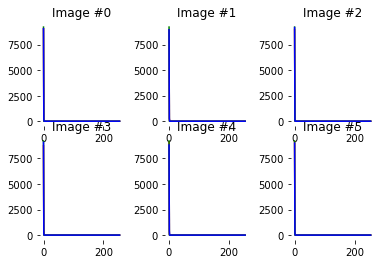

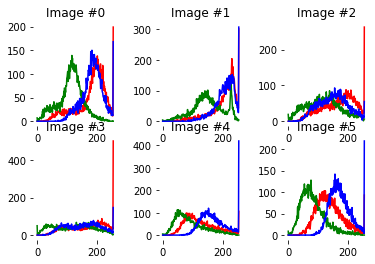

In [13]:
from skimage import exposure
from skimage.filters.rank import median
from skimage.morphology import disk, ball


imfiles_small_rescale = [exposure.equalize_hist(imfile)for imfile in imfiles_small]

showMultiplot(imfiles_small_rescale, "With rescaling")
showMultiplot(imfiles_small, "Without rescaling")

viewHists_color(imfiles_small_rescale)
viewHists_color(imfiles_small)

## Image Transformation - Histogram Equalization
Histogram equalization enhances contrast by spreading data across its full range 
https://en.wikipedia.org/wiki/Histogram_equalization
    
below we'll build a simple pipeline that:
 - de-noises some images
 - performs global histogram equalization
 - generates a binary mask from an otsu threshold
 - performs object detection on the binary mask
 - performs some object analysis on the detected objects
    

estimated noise standard deviation = 0.08514995204438841


/Users/johnalanwillis/anaconda3/envs/ilcproj/lib/python3.7/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


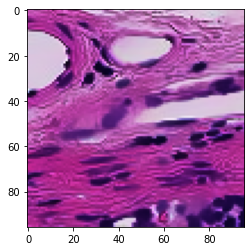

In [14]:
from skimage import exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise, img_as_float

imfiles_small_eqHist = [exposure.equalize_hist(imfile) for imfile in imfiles_small]

testimage=img_as_float(imfiles_small_eqHist[1])

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(testimage, multichannel=True))
print(f"estimated noise standard deviation = {sigma_est}")

patch_kw = dict(patch_size=3,      # 5x5 patches
                patch_distance=4,  # 13x13 search area
                multichannel=True)

# fast algorithm, sigma provided
test_nlmdn_hOne = denoise_nl_means(testimage, h=.1, sigma=sigma_est,
                                 fast_mode=True, **patch_kw)
plt.imshow(testimage)
plt.imshow(test_nlmdn_hOne)

/Users/johnalanwillis/anaconda3/envs/ilcproj/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Image dtype is not float. By default denoise_nl_means will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.19 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.
  


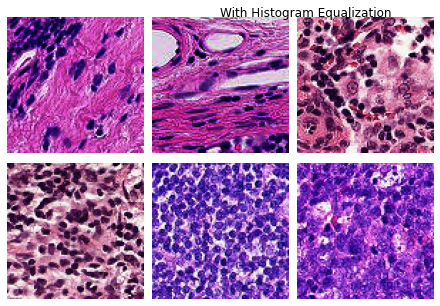

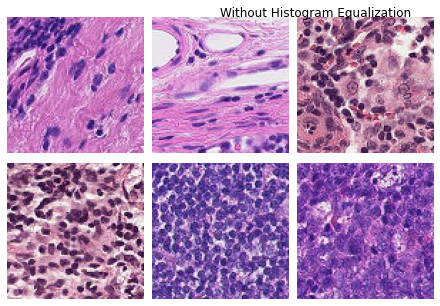

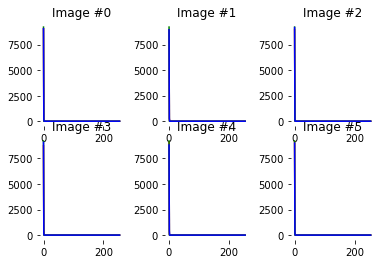

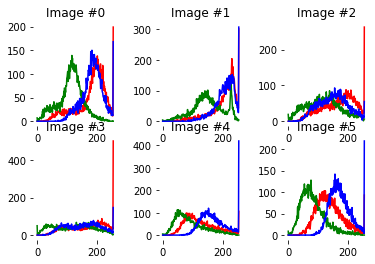

In [15]:
imfiles_small_denoise_eqHist = [exposure.equalize_hist(denoise_nl_means(imfile, h=.1, sigma=sigma_est,
                                 fast_mode=True, **patch_kw)) for imfile in imfiles_small]


showMultiplot(imfiles_small_denoise_eqHist, "With Histogram Equalization")
showMultiplot(imfiles_small, "Without Histogram Equalization")

viewHists_color(imfiles_small_denoise_eqHist)
viewHists_color(imfiles_small)

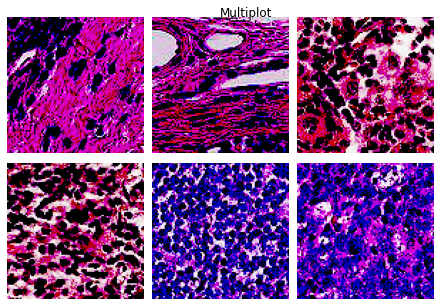

In [16]:
showMultiplot([applyThresholdMask(imfile, 150) for imfile in imfiles_small_eqHist])

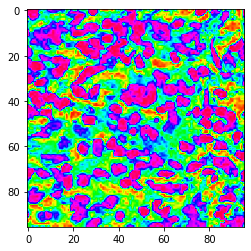

In [17]:
import skimage.measure
from skimage.util import invert 
from skimage.filters import gaussian, threshold_otsu


testimage=rgb2gray(invert(imfiles_small_eqHist[3]))
threshVal=threshold_otsu(testimage)
#threshVal = 210

plt.imshow(applyThresholdMask(testimage, threshVal))


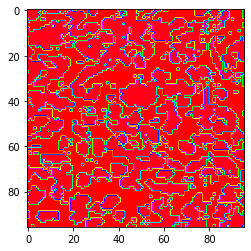

In [18]:

# image produced by the unblurred, otsu thresholded 
binMask=testimage < (threshVal)
plt.imshow(invert(binMask))



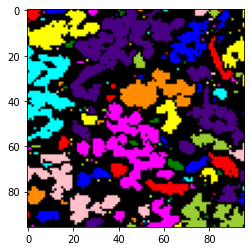

In [19]:
# Perform CCA on the mask
labeled_image = skimage.measure.label(invert(binMask), connectivity=1)
plt.imshow(skimage.color.label2rgb(labeled_image, bg_label=0))




we see with histogram equalization, otsu thresholding, and connectivity measurement, we are not doing a great job segmenting out nuclei

## Local Color normalization 
### Adaptive histogram equalization
https://en.wikipedia.org/wiki/Adaptive_histogram_equalization
by computing and spreading data based on local histograms, we can enhance the contrast and edges in our data 
the `clip_limit` can enhance the sharpness of the contrast from 0-1



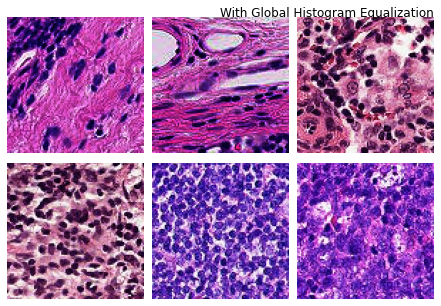

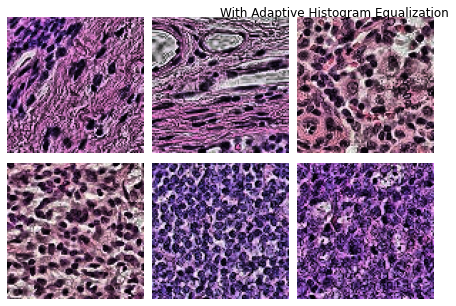

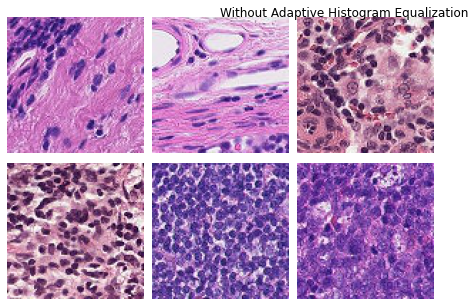

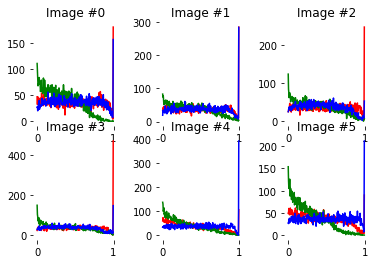

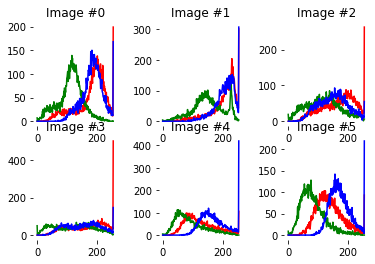

In [20]:

## Local Color normalization
imfiles_small_adaptEqHist = [exposure.equalize_adapthist(imfile, clip_limit=0.2) for imfile in imfiles_small]

showMultiplot(imfiles_small_denoise_eqHist, "With Global Histogram Equalization")
showMultiplot(imfiles_small_adaptEqHist, "With Adaptive Histogram Equalization")
showMultiplot(imfiles_small, "Without Adaptive Histogram Equalization")

viewHists_color_hsv(imfiles_small_adaptEqHist)
viewHists_color(imfiles_small)

## Color transfer and normalization
When working with large groups of images prepared on different days, or from different sources, or even of different tissues, you may find that batch associated processing artefacts influence the color profile of images.  
By deriving a target color profile and transforming the color profiles of the dataset under investigation to better conform to that profile, ther may be better discriminatory power in the dataset

### Reinhard
http://ieeexplore.ieee.org/document/946629/
The Reinhard method of color transfer/normalization involves transforming RGB-images to the lab orthogonal colorspace. 
The distribution of intensity across the three channels in decorrelated lab space is mapped between images


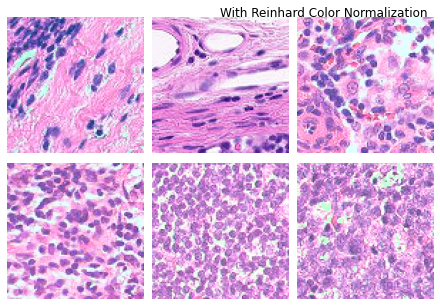

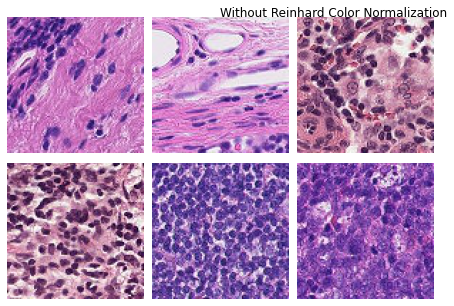

In [21]:
import Stain_Normalization
import stain_utils 
from Stain_Normalization import stainNorm_Reinhard

testImage = imfiles_small[1]

#Instantiate a normalizer and train it on the model image
n=stainNorm_Reinhard.Normalizer()
n.fit(testImage)

#apply the Reinhard normalization method to the images 
imfiles_small_reinhard=[n.transform(imfile) for imfile in imfiles_small]


showMultiplot(imfiles_small_reinhard, "With Reinhard Color Normalization")
showMultiplot(imfiles_small, "Without Reinhard Color Normalization")

notice that the transformation considerably brightens many of the images, and enhances the contrast between nuclei and cytoplasm regardless of compartment


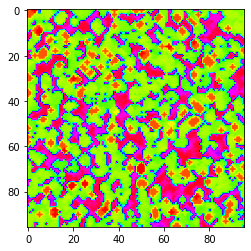

In [51]:
import skimage.measure
from skimage.util import invert 
from skimage.filters import gaussian, threshold_otsu

from skimage import img_as_float, img_as_ubyte
from skimage.morphology import opening, closing

def applyThresholdMask_OpClose(imageFile, threshold): 
    workingIm = img_as_ubyte(imageFile)
    mask = workingIm < threshold
    workingIm[mask] = 0
    #workingIm= opening(workingIm)
    workingIm= closing(workingIm)
    
    return workingIm


testimage=rgb2gray(imfiles_small_reinhard[4])
threshVal=threshold_otsu(testimage)
#threshVal = 210

plt.imshow(closing(closing(applyThresholdMask_OpClose(testimage, threshVal))))



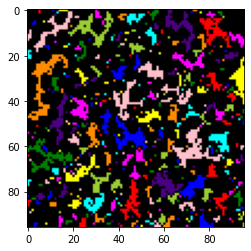

In [52]:
# image produced by the unblurred, otsu thresholded 
binMask=testimage > threshold_otsu(testimage)
#plt.imshow(binMask)

# Perform CCA on the mask
labeled_image = skimage.measure.label(binMask, connectivity=1)
plt.imshow(skimage.color.label2rgb(labeled_image, bg_label=0))

/Users/johnalanwillis/anaconda3/envs/ilcproj/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (96, 96, 3) looks like an RGB image
  import sys


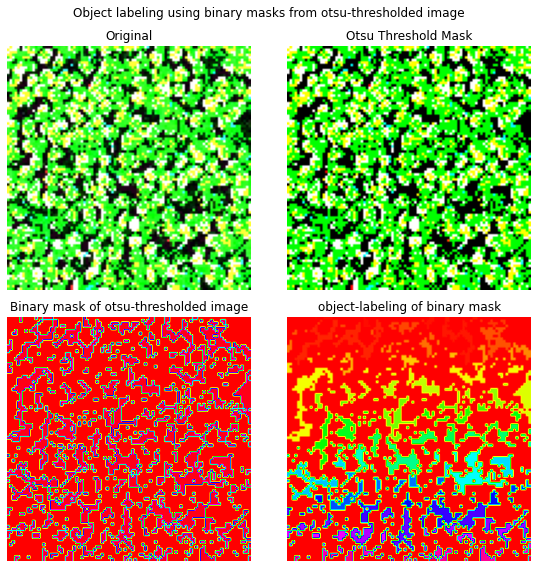

In [43]:

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8,8))
ax =axes.ravel()
testimage=invert(imfiles_small_reinhard[4])
ax[0].imshow(testimage)
ax[0].set_title("Original")

ax[1].imshow(applyThresholdMask(testimage, threshold_otsu(testimage)))
ax[1].set_title("Otsu Threshold Mask")

ax[2].imshow(binMask)
ax[2].set_title("Binary mask of otsu-thresholded image")

ax[3].imshow(labeled_image)
ax[3].set_title("object-labeling of binary mask")

for a in ax: 
    a.axis("off")

plt.suptitle("Object labeling using binary masks from otsu-thresholded image")
plt.tight_layout()
plt.show()




In [ ]:



viewHists_color(imfiles_small_reinhard)
viewHists_color(imfiles_small)

the histograms of the reinhard-transformed images are difficult to interpret, due to the spike at 255


### Macenko
http://ieeexplore.ieee.org/document/5193250/

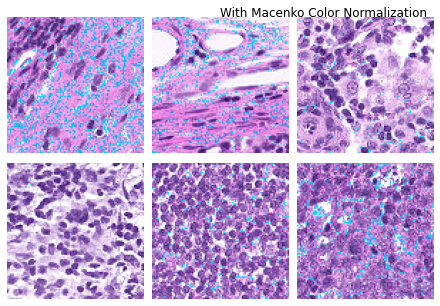

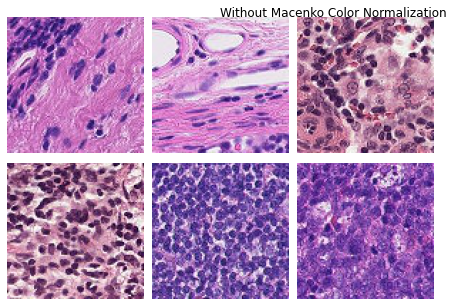

In [25]:
from Stain_Normalization import stainNorm_Macenko



testImage = imfiles_small[1]

#Instantiate a normalizer and train it on the model image
n=stainNorm_Macenko.Normalizer()
n.fit(testImage)

#apply the Reinhard normalization method to the images 
imfiles_small_macenko=[n.transform(imfile) for imfile in imfiles_small]


showMultiplot(imfiles_small_macenko, "With Macenko Color Normalization")
showMultiplot(imfiles_small, "Without Macenko Color Normalization")

The Macenko normalization approach produces confusing results, emphasizing ????

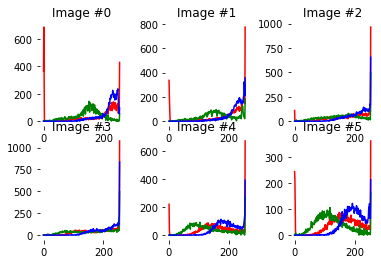

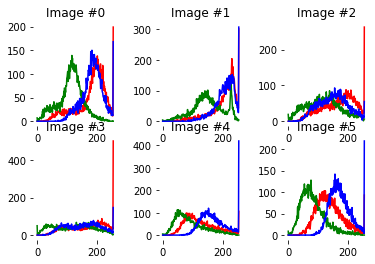

In [26]:
viewHists_color(imfiles_small_macenko)
viewHists_color(imfiles_small)


### Vahadane

http://ieeexplore.ieee.org/document/7164042/)
    


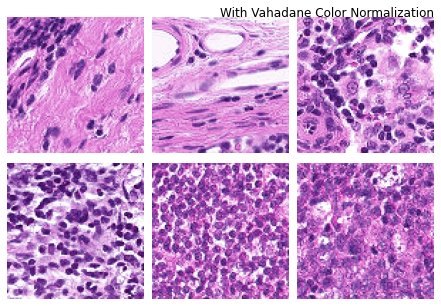

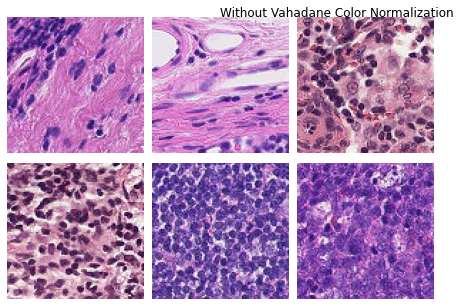

In [27]:
from Stain_Normalization import stainNorm_Vahadane


testImage = imfiles_small[1]

#Instantiate a normalizer and train it on the model image
n=stainNorm_Vahadane.Normalizer()
n.fit(testImage)

#apply the Reinhard normalization method to the images 
imfiles_small_vahadane=[n.transform(imfile) for imfile in imfiles_small]


showMultiplot(imfiles_small_vahadane, "With Vahadane Color Normalization")
showMultiplot(imfiles_small, "Without Vahadane Color Normalization")

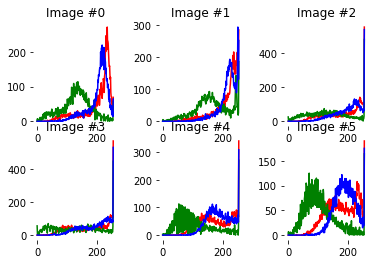

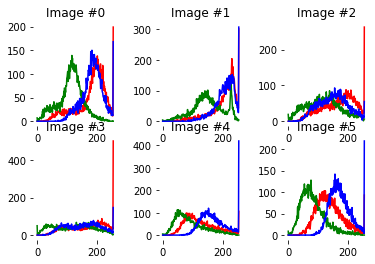

In [28]:
viewHists_color(imfiles_small_vahadane)
viewHists_color(imfiles_small)